<a href="https://colab.research.google.com/github/norgaston/laboratorio2-mlbd/blob/main/Laboratorio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio 2 - Clasificador de canciones de Spotify**

ELEMENTOS DE APRENDIZAJE DE MÁQUINA Y BIG DATA

Carrera: T.U. TECNOLOGÍAS DE PROGRAMACIÓN SEDE PUNTA ALTA
Facultad: Facultad de la Micro, Pequeña y Mediana Empresa (UPSO)
Docente: Valentín Barco
Cuatrimestre/Año: 2° Cuatrimestre 2023

En este laboratorio, nos enfocaremos en un conjunto de datos repleto de atributos clave de
distintas canciones. La meta es establecer a través de herramientas de aprendizaje
automático, un clasificador que pueda predecir las inclinaciones musicales de un individuo y
predecir si disfrutará o no de una determinada canción.

**Integrantes del Grupo 12: Dolores Ponce y Gaston Ponce**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importa las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Carga los datos en un DataFrame de Pandas
ruta = '/content/Canciones_Spotify.csv' # ruta desde donde voy a cargar el dataset
data = pd.read_csv(ruta, encoding='latin-1')
data = data.dropna()
# Elimino la primera columna (columna 0) utilizando el método drop
data.drop('Unnamed: 0', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  song_title        2017 non-null   object 
 15  artist            2017 non-null   object 
dtypes: float64(10), int64(4), object(2)
memory

# **Análisis exploratorio de los datos**

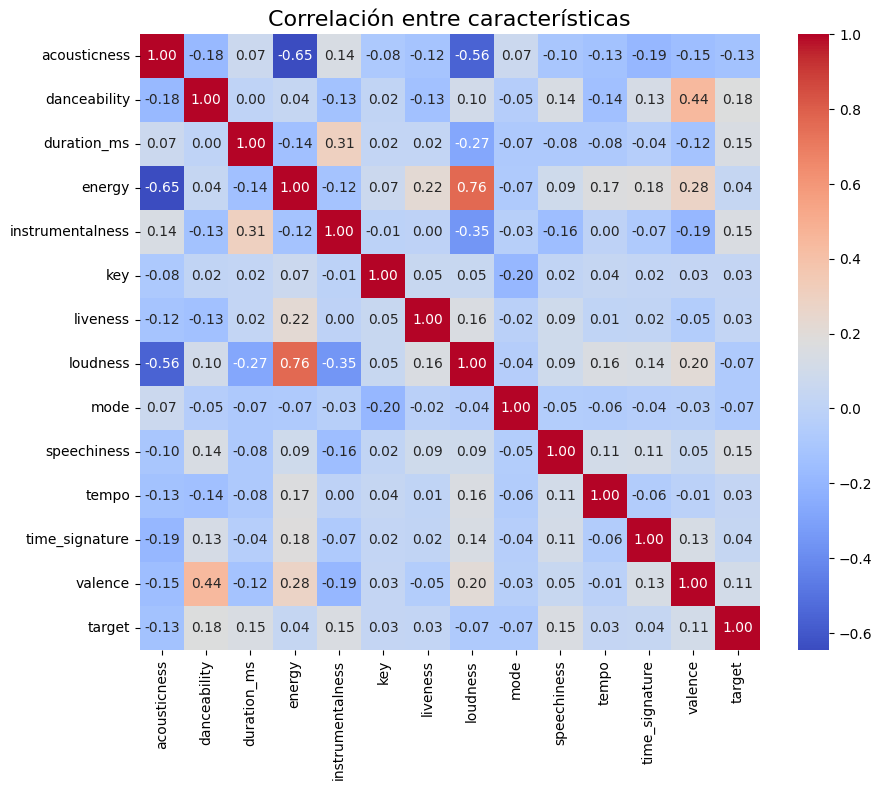

In [3]:
correlation_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre características', fontsize=16)
plt.show()

In [4]:
# Función para graficar la matriz de confusión con valores
def plot_confusion_matrix_with_values(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    classes = ['No Gusta', 'Gusta']
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center', color='black', fontsize=15)
    plt.xticks([0, 1], classes, rotation=45)
    plt.yticks([0, 1], classes)
    plt.tight_layout()
    plt.ylabel('Canciones Verdaderas')
    plt.xlabel('Canciones Predichas')

# Función para graficar la curva ROC y calcular el AUC
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

In [5]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = data.drop(['target', 'song_title', 'artist'], axis=1)
y = data['target']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Escalado de los datos
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# Configurar hiperparámetros
knn_model = KNeighborsClassifier(algorithm='ball_tree',n_neighbors=19,p=1,weights='distance')
svm_model = SVC(C=1.5, class_weight='balanced', gamma='scale', kernel='rbf',probability=True)
decision_tree_model = DecisionTreeClassifier(random_state=42,ccp_alpha=0.001)
naive_bayes_model = GaussianNB()
rf_model = RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300, oob_score=True, ccp_alpha=0.0004)

# Entrenar modelos
knn_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
naive_bayes_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Realizar predicciones
knn_predictions = knn_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)
decision_tree_predictions = decision_tree_model.predict(X_test)
naive_bayes_predictions = naive_bayes_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

# **Evaluación de los modelos**

**K-Nearest Neighbors**

K-Nearest Neighbors:
[[174  32]
 [ 86 112]]
              precision    recall  f1-score   support

           0       0.67      0.84      0.75       206
           1       0.78      0.57      0.65       198

    accuracy                           0.71       404
   macro avg       0.72      0.71      0.70       404
weighted avg       0.72      0.71      0.70       404



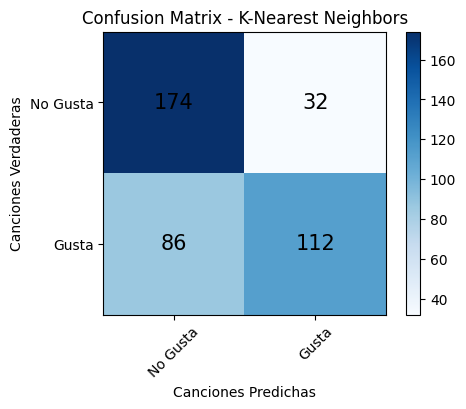

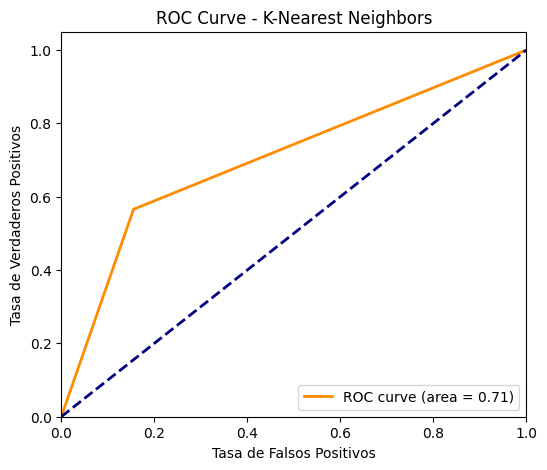

In [6]:
print("K-Nearest Neighbors:")
print(confusion_matrix(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))

plot_confusion_matrix_with_values(y_test, knn_predictions, 'K-Nearest Neighbors')
plt.show()
plot_roc_curve(y_test, knn_predictions, 'K-Nearest Neighbors')
plt.show()

**Support Vector Machine**

Support Vector Machine:
[[162  44]
 [ 64 134]]
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       206
           1       0.75      0.68      0.71       198

    accuracy                           0.73       404
   macro avg       0.73      0.73      0.73       404
weighted avg       0.73      0.73      0.73       404



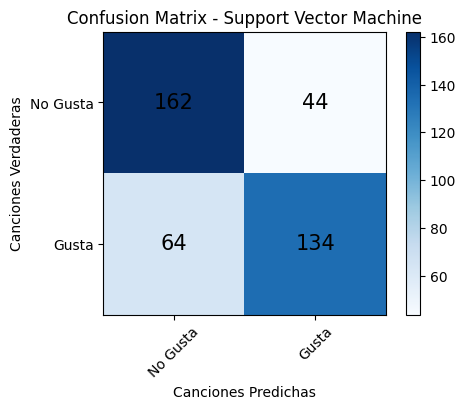

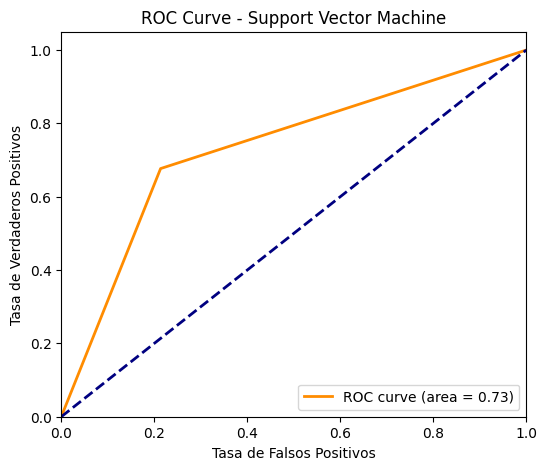

In [7]:
print("Support Vector Machine:")
print(confusion_matrix(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))

plot_confusion_matrix_with_values(y_test, svm_predictions, 'Support Vector Machine')
plt.show()
plot_roc_curve(y_test, svm_predictions, 'Support Vector Machine')
plt.show()

**Decision Tree**

Decision Tree:
[[149  57]
 [ 63 135]]
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       206
           1       0.70      0.68      0.69       198

    accuracy                           0.70       404
   macro avg       0.70      0.70      0.70       404
weighted avg       0.70      0.70      0.70       404



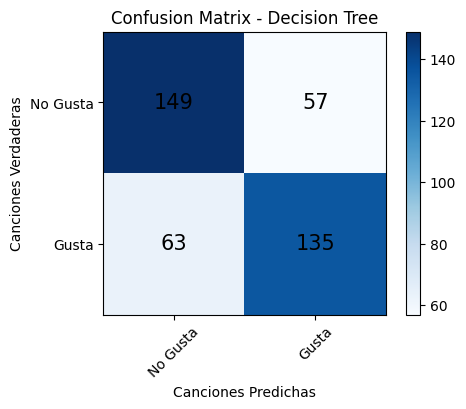

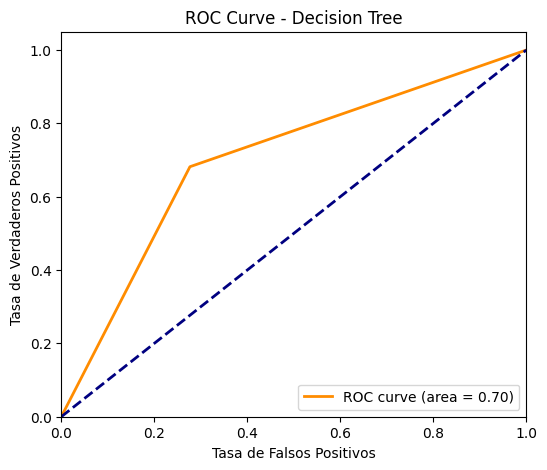

In [8]:
print("Decision Tree:")
print(confusion_matrix(y_test, decision_tree_predictions))
print(classification_report(y_test, decision_tree_predictions))

plot_confusion_matrix_with_values(y_test, decision_tree_predictions, 'Decision Tree')
plt.show()
plot_roc_curve(y_test, decision_tree_predictions, 'Decision Tree')
plt.show()

**Naive Bayes**

Naive Bayes:
[[116  90]
 [ 58 140]]
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       206
           1       0.61      0.71      0.65       198

    accuracy                           0.63       404
   macro avg       0.64      0.64      0.63       404
weighted avg       0.64      0.63      0.63       404



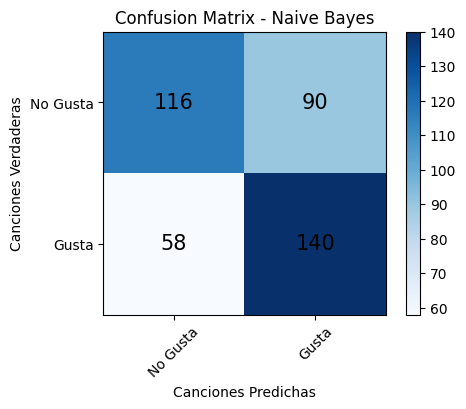

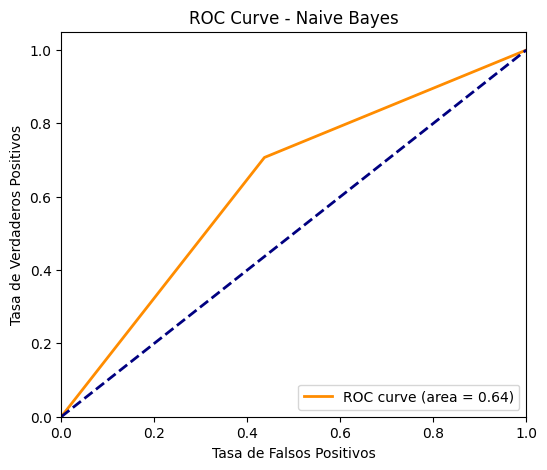

In [9]:
print("Naive Bayes:")
print(confusion_matrix(y_test, naive_bayes_predictions))
print(classification_report(y_test, naive_bayes_predictions))

plot_confusion_matrix_with_values(y_test, naive_bayes_predictions, 'Naive Bayes')
plt.show()
plot_roc_curve(y_test, naive_bayes_predictions, 'Naive Bayes')
plt.show()

**Random Forest**

Random Forest:
[[161  45]
 [ 44 154]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       206
           1       0.77      0.78      0.78       198

    accuracy                           0.78       404
   macro avg       0.78      0.78      0.78       404
weighted avg       0.78      0.78      0.78       404



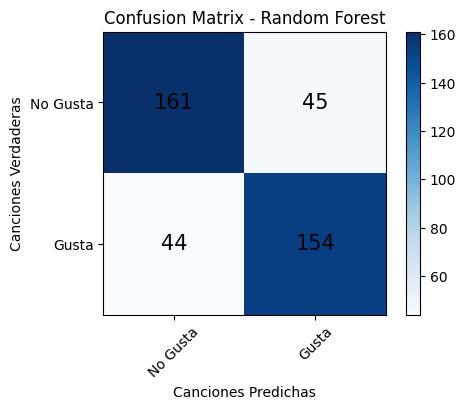

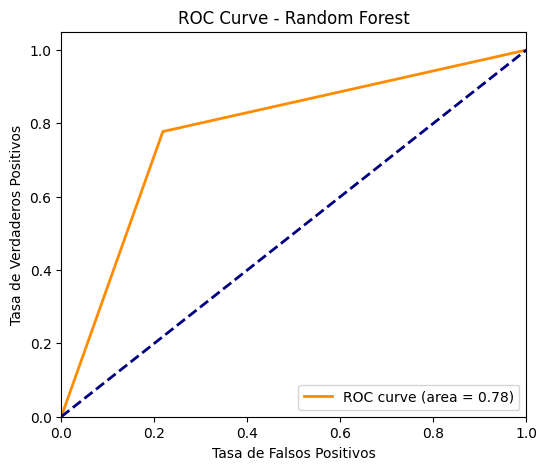

In [10]:
print("Random Forest:")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

plot_confusion_matrix_with_values(y_test, rf_predictions, 'Random Forest')
plt.show()
plot_roc_curve(y_test, rf_predictions, 'Random Forest')
plt.show()

**Votación Mayoritaria**

Ensamble (Votación Mayoritaria):
[[170  36]
 [ 60 138]]
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       206
           1       0.79      0.70      0.74       198

    accuracy                           0.76       404
   macro avg       0.77      0.76      0.76       404
weighted avg       0.77      0.76      0.76       404



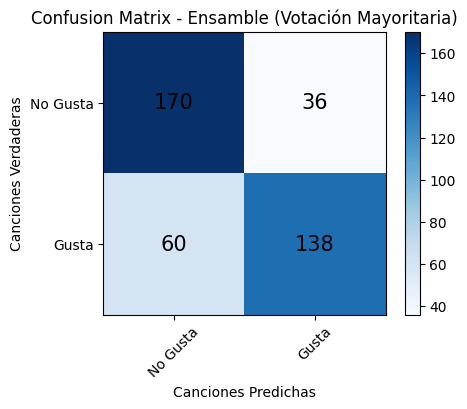

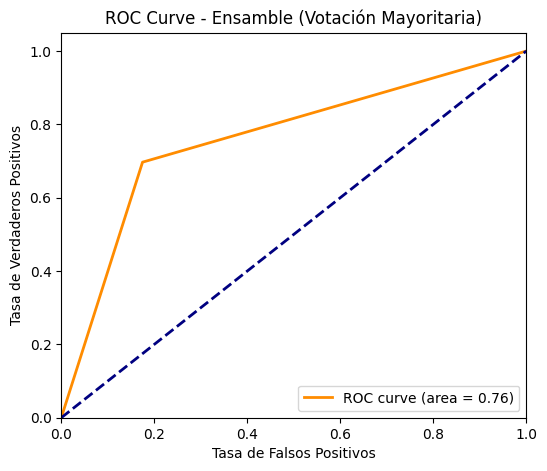

In [11]:
# Ensamble de modelos (Votación mayoritaria)
ensemble_model = VotingClassifier(estimators=[('KNN', knn_model), ('SVM', svm_model), ('DecisionTree', decision_tree_model), ('NaiveBayes', naive_bayes_model), ('RandomForest', rf_model)], voting='hard')
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)

# Evaluar el ensamble
print("Ensamble (Votación Mayoritaria):")
print(confusion_matrix(y_test, ensemble_predictions))
print(classification_report(y_test, ensemble_predictions))

plot_confusion_matrix_with_values(y_test, ensemble_predictions, 'Ensamble (Votación Mayoritaria)')
plt.show()
plot_roc_curve(y_test, ensemble_predictions, 'Ensamble (Votación Mayoritaria)')
plt.show()

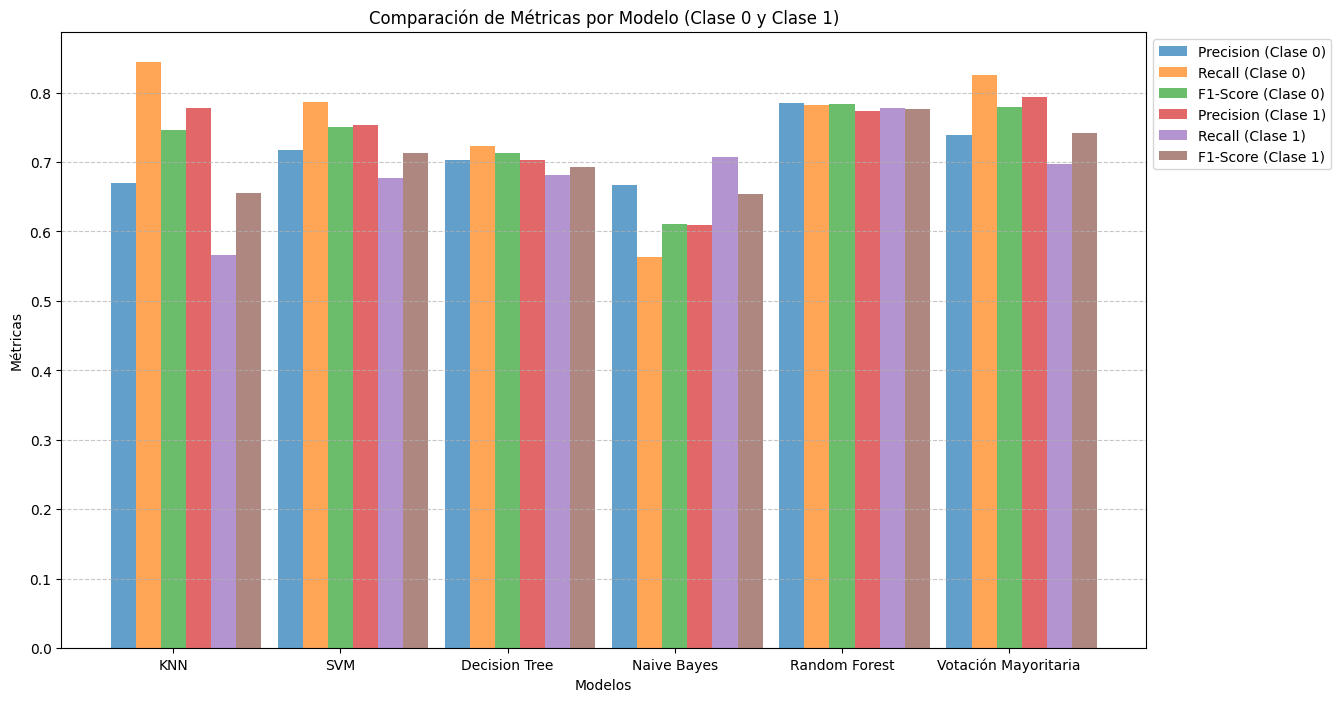

In [12]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Resultados de classification_report para cada modelo
report_knn = classification_report(y_test, knn_predictions, output_dict=True)
report_svm = classification_report(y_test, svm_predictions, output_dict=True)
report_decision_tree = classification_report(y_test, decision_tree_predictions, output_dict=True)
report_naive_bayes = classification_report(y_test, naive_bayes_predictions, output_dict=True)
report_rf = classification_report(y_test, rf_predictions, output_dict=True)
report_ensemble = classification_report(y_test, ensemble_predictions, output_dict=True)

# Métricas y modelos
metrics = ['precision', 'recall', 'f1-score']
models = ['KNN', 'SVM', 'Decision Tree', 'Naive Bayes', 'Random Forest', 'Votación Mayoritaria']

# Valores de métricas para ambas clases y modelos
precision_values_class_0 = [report_knn['0']['precision'], report_svm['0']['precision'], report_decision_tree['0']['precision'], report_naive_bayes['0']['precision'], report_rf['0']['precision'], report_ensemble['0']['precision']]
recall_values_class_0 = [report_knn['0']['recall'], report_svm['0']['recall'], report_decision_tree['0']['recall'], report_naive_bayes['0']['recall'], report_rf['0']['recall'], report_ensemble['0']['recall']]
f1_score_values_class_0 = [report_knn['0']['f1-score'], report_svm['0']['f1-score'], report_decision_tree['0']['f1-score'], report_naive_bayes['0']['f1-score'], report_rf['0']['f1-score'], report_ensemble['0']['f1-score']]

precision_values_class_1 = [report_knn['1']['precision'], report_svm['1']['precision'], report_decision_tree['1']['precision'], report_naive_bayes['1']['precision'], report_rf['1']['precision'], report_ensemble['1']['precision']]
recall_values_class_1 = [report_knn['1']['recall'], report_svm['1']['recall'], report_decision_tree['1']['recall'], report_naive_bayes['1']['recall'], report_rf['1']['recall'], report_ensemble['1']['recall']]
f1_score_values_class_1 = [report_knn['1']['f1-score'], report_svm['1']['f1-score'], report_decision_tree['1']['f1-score'], report_naive_bayes['1']['f1-score'], report_rf['1']['f1-score'], report_ensemble['1']['f1-score']]

# Configuración del gráfico
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = range(len(models))

# Crear gráfico de barras para precisión (Clase 0)
plt.bar(index, precision_values_class_0, bar_width, label='Precision (Clase 0)', alpha=0.7)
# Crear gráfico de barras para recall (Clase 0)
plt.bar([i + bar_width for i in index], recall_values_class_0, bar_width, label='Recall (Clase 0)', alpha=0.7)
# Crear gráfico de barras para f1-score (Clase 0)
plt.bar([i + 2 * bar_width for i in index], f1_score_values_class_0, bar_width, label='F1-Score (Clase 0)', alpha=0.7)

# Crear gráfico de barras para precisión (Clase 1)
plt.bar([i + 3 * bar_width for i in index], precision_values_class_1, bar_width, label='Precision (Clase 1)', alpha=0.7)
# Crear gráfico de barras para recall (Clase 1)
plt.bar([i + 4 * bar_width for i in index], recall_values_class_1, bar_width, label='Recall (Clase 1)', alpha=0.7)
# Crear gráfico de barras para f1-score (Clase 1)
plt.bar([i + 5 * bar_width for i in index], f1_score_values_class_1, bar_width, label='F1-Score (Clase 1)', alpha=0.7)

plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.title('Comparación de Métricas por Modelo (Clase 0 y Clase 1)')

# Ajustar la posición de la leyenda fuera del gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks([i + 2 * bar_width for i in index], models)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# **Conclusiones:**

En esta tabla, se puede ver claramente cómo cada modelo se desempeña en términos de precisión, recall, f1-score y exactitud para ambas clases.

---



|      Modelo               | Precisión (Clase 0) | Recall (Clase 0) | F1-Score (Clase 0) | Precisión (Clase 1) | Recall (Clase 1) | F1-Score (Clase 1) | F1-Score Promedio | Exactitud | Soporte |
|--------------------------|---------------------|-------------------|--------------------|---------------------|-------------------|--------------------|--------------------|-----------|---------|
| Random Forest              | 0.80                | 0.78              | 0.79               | 0.77                | 0.79              | 0.78               | 0.785              | 0.78      | 404     |
| Votación Mayoritaria       | 0.75                | 0.82              | 0.78               | 0.79                | 0.71              | 0.75               | 0.765              | 0.77      | 404     |
| Support Vector Machine (SVM) | 0.72                | 0.79              | 0.75               | 0.75                | 0.68              | 0.71               | 0.73               | 0.73      | 404     |
| Decision Tree              | 0.70                | 0.72              | 0.71               | 0.70                | 0.68              | 0.69               | 0.70               | 0.70      | 404     |
| K-Nearest Neighbors (KNN) | 0.67                | 0.84              | 0.75               | 0.78                | 0.57              | 0.65               | 0.70               | 0.71      | 404     |
| Naive Bayes                | 0.67                | 0.56              | 0.61               | 0.61                | 0.71              | 0.65               | 0.63               | 0.63      | 404     |






Basándonos en los resultados de los modelos de clasificación en este estudio de canciones de Spotify, podemos hacer las siguientes conclusiones:

**Random Forest:** Random Forest destacó con una alta precisión y recall en ambas clases, lo que resultó en un sólido f1-score y una alta exactitud general del 78%. Este modelo se destaca como uno de los mejores en este estudio.

**Votación Mayoritaria:** El ensamblaje de modelos mediante votación mayoritaria combinó las fortalezas de varios modelos, lo que resultó en una alta precisión, recall, f1-score y exactitud en ambas clases. La exactitud general alcanzó el 77%, lo que sugiere que este enfoque de ensamblaje puede ser una estrategia efectiva.

**Support Vector Machine:** SVM proporcionó resultados sólidos con una precisión cercana al 73% en la clase 1. La f1-score también fue buena para ambas clases, y la exactitud general alcanzó el 73%. Esto sugiere que SVM es un modelo prometedor para este conjunto de datos.

**Decision Tree:** El árbol de decisión demostró un desempeño equilibrado con precisión y recall similares en ambas clases. La exactitud general fue del 70%. Aunque es una opción válida, podría haber margen para mejorar aún más.

**K-Nearest Neighbors:** Este modelo mostró una precisión razonable en ambas clases (0 y 1), pero su f1-score fue ligeramente más bajo en la clase 1. A pesar de eso, logró un nivel aceptable de exactitud general del 71%. Esto indica que KNN puede ser una opción viable, pero aún se beneficiaría de algunas mejoras en la precisión y el recall.

**Naive Bayes:** El modelo Naive Bayes tuvo un desempeño moderado, con un f1-score decente en la clase 1, pero una precisión más baja en la misma clase. La exactitud general se situó en el 63%. Este modelo puede necesitar más ajustes y consideración.

En resumen, los resultados indican que tanto Random Forest como la votación mayoritaria son las opciones más prometedoras para predecir las preferencias musicales de un individuo en este conjunto de datos. Sin embargo, la elección del modelo final dependerá de otros factores, como la escalabilidad y la interpretación de los resultados.